#Assignment 03
#Muhammad Ali Reg no 329159
##MS DS 2k20 Computer Vision

###Testing U-Net Models

###Installing Libraries

In [1]:
!pip install te
!pip install keras.utils
!pip install -U segmentation-models
!pip install -U --pre segmentation-models

     |████████████████████████████████| 489 kB 5.0 MB/s 
     |████████████████████████████████| 156 kB 53.1 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 141 kB 57.9 MB/s 
     |████████████████████████████████| 125 kB 53.3 MB/s 
     |████████████████████████████████| 227 kB 47.7 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
     |████████████████████████████████| 57 kB 4.7 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Successfully uninstalled python-dateutil-2.8.2
  Attempting uninstall: idna
    Found existing insta

  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=7b8bdb3e4c8efaf1ce18c6ee46d6bc0983456b6707b55d88eb698c4acacc9087
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils
     |████████████████████████████████| 50 kB 5.1 MB/s 


###Importing Libraries

In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


###Mounting Drive

In [3]:
SIZE_X = 224 
SIZE_Y = 224
n_classes=12 

from google.colab import drive
drive.mount('/content/drive')
train_path_imgs = 'drive/My Drive/Datasets/SemSegDataSet/images_prepped_train'
test_path_imgs = 'drive/My Drive/Datasets/SemSegDataSet/images_prepped_test'
train_path_y = 'drive/My Drive/Datasets/SemSegDataSet/annotations_prepped_train'
test_path_y = 'drive/My Drive/Datasets/SemSegDataSet/annotations_prepped_test'

Mounted at /content/drive


###Reading Test Images

In [4]:
#Capture testing image info as a list
test_images = []

for directory_path in glob.glob(test_path_imgs):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = img / 255.0
        img = img.astype(np.float32)
        test_images.append(img)
       
#Convert list to array for machine learning processing        
test_images = np.array(test_images)

#Capture mask/label info as a list
test_masks = [] 
for directory_path in glob.glob(test_path_y):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        mask = mask.astype(np.int32)
        test_masks.append(mask)
        
#Convert list to array for machine learning processing          
test_masks = np.array(test_masks)


### Label Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

n1, h1, w1 = test_masks.shape

test_masks_reshaped = test_masks.reshape(-1,1)

test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)

test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n1, h1, w1)
test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3)
test_masks_cat = to_categorical(test_masks_input, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((test_masks_input.shape[0], test_masks_input.shape[1], test_masks_input.shape[2],n_classes))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model Parameters

In [6]:
activation='softmax'
import tensorflow as tf

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333,0.083333333])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

###Setting Framework

In [7]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

##Loading and Compling **Inception U-Net Model**

In [8]:
BACKBONE1 = 'inceptionv3'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input

X_test1 = preprocess_input1(test_images)

# define model
model1 = tf.keras.models.load_model('drive/My Drive/Model_H5_Files/inceptionv3_backbone_50epochs.hdf5', compile=False)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)



##Evaluation

In [12]:
result = model1.evaluate(X_test1, y_test_cat , verbose=0)

In [13]:
print('loss: '+str(result[0])+' - iou_score: '+str(result[1])+' - f1-score: '+str(result[1]))

loss: 1.0147289037704468 - iou_score: 0.19078829884529114 - f1-score: 0.19078829884529114


##Qualitative Prediction

In [9]:
%%timeit
predict1 = model1.predict(X_test1)

1 loop, best of 5: 28.9 s per loop


##Normalizing Results

In [15]:
result11 = np.zeros((predict1.shape[0],predict1.shape[1],predict1.shape[2]),dtype='int')
for n in range(predict1.shape[0]):
  for x in range(predict1.shape[1]):
    for y in range(predict1.shape[2]):
      temp = np.argmax(predict1[n,x,y],axis=0)
      result11[n,x,y]=temp

In [16]:
realtest_images = []

for directory_path in glob.glob(test_path_imgs):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        realtest_images.append(img)
realtest_masks = [] 
for directory_path in glob.glob(test_path_y):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        realtest_masks.append(mask)



##Printing Qualitative Results

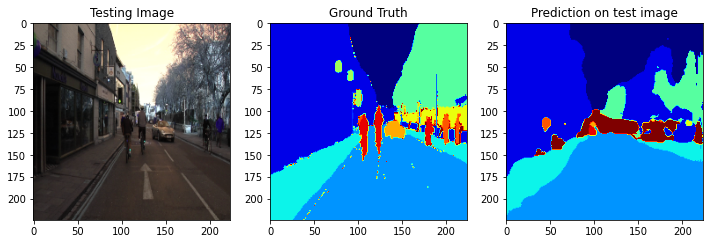

In [42]:

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(realtest_images[10])
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(realtest_masks[10],cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(result11[10],cmap='jet')
plt.show()

##Loading and Compiling **EfficientNet U-Net**

In [10]:
BACKBONE2 = 'efficientnetb7'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input

X_test2 = preprocess_input2(test_images)

# define model
model2 = tf.keras.models.load_model('drive/My Drive/Model_H5_Files/efficientnetb7_backbone_50epochs.hdf5', compile=False)

# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics=metrics)


## Evaluation

In [30]:
result2 = model2.evaluate(X_test2, y_test_cat , verbose=0)


In [31]:
print('loss: '+str(result2[0])+' - iou_score: '+str(result2[1])+' - f1-score: '+str(result2[1]))

loss: 1.0398815870285034 - iou_score: 0.13430313766002655 - f1-score: 0.13430313766002655


##Qualitative Prediction

In [11]:
%%timeit
predict2 = model2.predict(X_test2)

1 loop, best of 5: 59 s per loop


In [32]:
result22 = np.zeros((predict2.shape[0],predict2.shape[1],predict2.shape[2]),dtype='int')
for n in range(predict2.shape[0]):
  for x in range(predict2.shape[1]):
    for y in range(predict2.shape[2]):
      temp = np.argmax(predict2[n,x,y],axis=0)
      result22[n,x,y]=temp

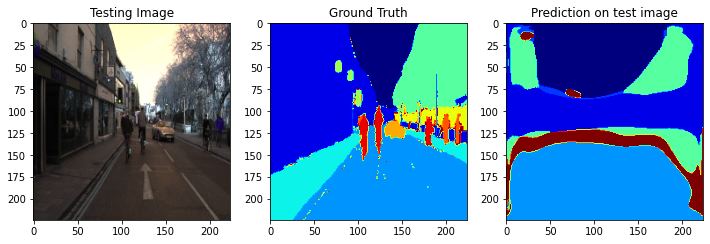

In [43]:

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(realtest_images[10])
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(realtest_masks[10],cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(result22[10],cmap='jet')
plt.show()